In [2]:
import pandas as pd
import numpy as np

pheno_train = pd.read_csv("train/pheno_training.csv")
pheno_test = pd.read_csv("test/pheno_test.csv")

pheno_train = pheno_train.dropna()
pheno_test = pheno_test.dropna()

## Pré processamento para ML

In [3]:
var = ["Event", "Event_time"]
pheno_train_y = pheno_train.PrevalentHFAIL + pheno_train.Event # data target with the patients that had HF before and after the first data collecting
pheno_train_y = pheno_train_y.map({2: 1, 0: 0, 1: 1}) # make the variable boolean
pheno_train_X = pheno_train.iloc[: , 1:] # Dropping the name of the patients
pheno_train_X = pheno_train_X.drop(columns = ["Event", "Event_time", "PrevalentHFAIL"]) # dropping the variables that we want to predict and event_time doesnt make sense  
pheno_test_y = pheno_test.PrevalentHFAIL + pheno_test.Event # data target with the patients that had HF before and after the first data collecting
pheno_test_y = pheno_test_y.map({2: 1, 0: 0, 1: 1}) # make the variable boolean
pheno_test_X = pheno_test.iloc[: , 1:] # Dropping the name of the patients
pheno_test_X = pheno_test_X.drop(columns = ["Event", "Event_time", "PrevalentHFAIL"]) # dropping the variables that we want to predict and event_time doesnt make sense
# SMOTE -> used for unbalanced data sets 
# Synthetic Minority Over-sampling Technique
from collections import Counter
print('Original dataset shape %s' % Counter(pheno_train_y))
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
pheno_train_X, pheno_train_y = sm.fit_resample(pheno_train_X, pheno_train_y)
print('Resampled dataset shape %s' % Counter(pheno_train_y))
#pheno_test_X, pheno_test_y = sm.fit_resample(pheno_test_X, pheno_test_y)


Original dataset shape Counter({0: 3157, 1: 383})
Resampled dataset shape Counter({0: 3157, 1: 3157})


## Modelos de ML
#### Logistic Regression

PECC (accuracy): 0.6252834467120182


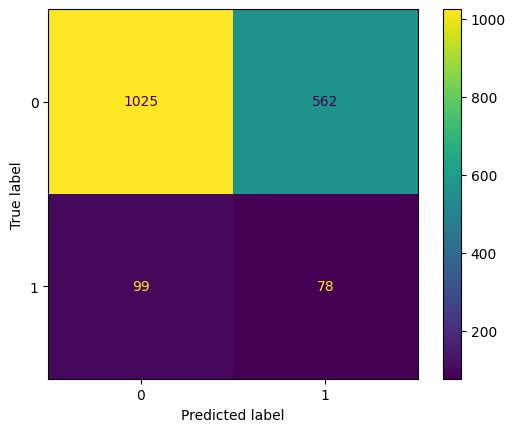

In [4]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

logistic = linear_model.LogisticRegression(C=1e5, solver = "liblinear", multi_class = "auto")
logistic = logistic.fit(pheno_train_X, pheno_train_y)
logistic_prev = logistic.predict(pheno_test_X)
print("PECC (accuracy):", accuracy_score(pheno_test_y, logistic_prev))

cm_logreg = confusion_matrix(pheno_test_y, logistic_prev, labels=logistic.classes_)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=logistic.classes_)
disp1.plot()
plt.show()

#### Linear Regression

In [5]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

regr_model = linear_model.LinearRegression()
regr_model = regr_model.fit(pheno_train_X, pheno_train_y)
regr_model_pred = regr_model.predict(pheno_test_X)

regr_model_pred = np.round(regr_model_pred)

print("PECC (accuracy):", accuracy_score(pheno_test_y, regr_model_pred))

PECC (accuracy): 0.623015873015873


#### Ridge


In [6]:
ridge = linear_model.Ridge(alpha=.1)
ridge = ridge.fit(pheno_train_X, pheno_train_y)
ridge_pred = ridge.predict(pheno_test_X)
ridge_pred = np.round(ridge_pred)

print("PECC (accuracy):", accuracy_score(pheno_test_y, ridge_pred))

PECC (accuracy): 0.623015873015873


Lasso

In [7]:
lasso = linear_model.Lasso()
lasso = lasso.fit(pheno_train_X, pheno_train_y)
lasso_pred = lasso.predict(pheno_test_X)
lasso_pred = np.round(lasso_pred)
print("PECC (accuracy):", accuracy_score(pheno_test_y, lasso_pred))


PECC (accuracy): 0.5396825396825397


#### SVM's

In [8]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
SVM = svm.SVC(gamma=0.001, C=100.)
SVM = SVM.fit(pheno_train_X, pheno_train_y)
svm_pred = SVM.predict(pheno_test_X)
print("PECC (accuracy):", accuracy_score(pheno_test_y, svm_pred))
#cross_scores = cross_val_score(SVM, pheno_test_y, svm_pred, cv = 5)
#print(cross_scores)


PECC (accuracy): 0.5617913832199547


#### KNeighborsClassifier

In [9]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(pheno_train_X, pheno_train_y)
knn_pred = knn.predict(pheno_test_X)
print("Perc. acertos: ", (knn_pred == pheno_test_y).sum()/len(knn_pred))

Perc. acertos:  0.6337868480725624


#### Decision Tree

Perc. acertos:  0.7488662131519275


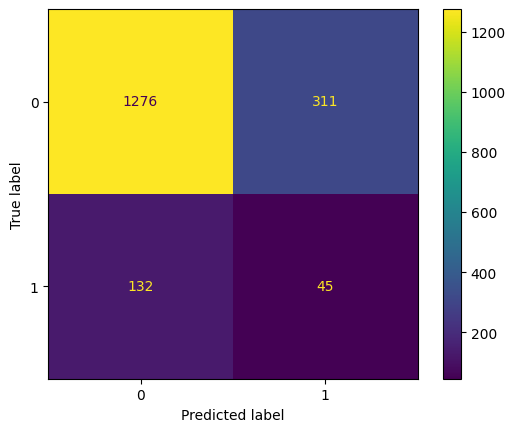

In [10]:
from sklearn import tree
from sklearn.metrics import f1_score

tree_model = tree.DecisionTreeClassifier()
tree_model = tree_model.fit(pheno_train_X, pheno_train_y)
preds_tree = tree_model.predict(pheno_test_X)

print("Perc. acertos: ", (preds_tree == pheno_test_y).sum()/len(preds_tree))

cm_tree = confusion_matrix(pheno_test_y, preds_tree, labels=tree_model.classes_)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=tree_model.classes_)
disp_tree.plot()
plt.show()

## Ensembles
#### Voting Classifier

In [11]:
from sklearn.ensemble import VotingClassifier
DTree = tree.DecisionTreeClassifier(max_depth=4)
knn_class = KNeighborsClassifier(n_neighbors=7)
svc = svm.SVC(gamma='scale', kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', DTree), ('knn', knn_class), ('svc', svc)], voting='hard')

eclf = eclf.fit(pheno_train_X, pheno_train_y)
print(eclf.score(pheno_test_X, pheno_test_y))

0.6031746031746031


In [13]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

#### Random Forest Classifier

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100)
param_dist = {"max_depth": [2, 3, None], "max_features": [2,4,6], "min_samples_split": [2,4,6],
              "min_samples_leaf": [2,4,6], "bootstrap": [True, False], "criterion": ["gini", "entropy"]}

rand_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=20, cv = 5)
rand_search =rand_search.fit(pheno_train_X, pheno_train_y)
print (rand_search.best_estimator_)
report(rand_search.cv_results_)
print(rand_search.score(pheno_test_X, pheno_test_y))

RandomForestClassifier(bootstrap=False, max_features=6, min_samples_leaf=2)
Model with rank: 1
Mean validation score: 0.882 (std: 0.055)
Parameters: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 6, 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}

Model with rank: 2
Mean validation score: 0.867 (std: 0.058)
Parameters: {'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 6, 'max_depth': None, 'criterion': 'entropy', 'bootstrap': False}

Model with rank: 3
Mean validation score: 0.861 (std: 0.064)
Parameters: {'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 4, 'max_depth': None, 'criterion': 'gini', 'bootstrap': True}

0.814625850340136


#### SVM Random Search

In [15]:
parameters = {'kernel':('linear', 'rbf'), 'C':[0.1, 0.5, 1, 3, 10, 30, 100, 1000], 'gamma':[0.1, 0.01, 0.05, 0.001]}
svm_model_d = svm.SVC()
rand_search = RandomizedSearchCV(svm_model_d, param_distributions=parameters, n_iter=20, cv = 5)

rand_search.fit(pheno_train_X, pheno_train_y)

print (rand_search.best_estimator_)
report(rand_search.cv_results_)
print(rand_search.score(pheno_test_X, pheno_test_y))
# Demorou 31 min a correr


SVC(C=10, gamma=0.1)
Model with rank: 1
Mean validation score: 0.900 (std: 0.008)
Parameters: {'kernel': 'rbf', 'gamma': 0.1, 'C': 10}

Model with rank: 2
Mean validation score: 0.894 (std: 0.011)
Parameters: {'kernel': 'rbf', 'gamma': 0.05, 'C': 10}

Model with rank: 3
Mean validation score: 0.891 (std: 0.006)
Parameters: {'kernel': 'rbf', 'gamma': 0.05, 'C': 1000}

0.7845804988662132
